# Harmonizing starMAP dataset and Saunders's Dropseq dataset

# Table of Contents
1. [Creating and training the model](#Creating and training the model)
2. [Creating and training the original scVI model as a baseline](#Creating and training the original scVI model as a baseline)
3. [Imputation](#Imputation)
4. [Getting a common meaningful representation](#Getting a common meaningful representation)
5. [Classifying starMAP cells in different cell types](#Classifying starMAP cells in different cell types)
6. [Imputation of non-observed genes for starMAP](#Imputation of non-observed genes for starMAP)

## Imputation
We train our model and the baseline without observing some starMAP genes . We then try to reconstruct the unobserved values for each cell, an compare them with the real ones. 
For the baseline we use a k-NN approach, and for our model we directly output the expected counts.
We also compute, for each of those unobserved genes, the absolute and relative errors.
## Getting a common meaningful representation
Here, we'd like two things. First, the two datasets should mix pretty well (if the common representation captures biologically relevant information). This is measured by the Entropy of Batch Mixing (maximum possible value: 0.68, minimum possible value: 0.00, value for our method: 0.50, value for baseline: 0.10).
We also plot the latent represnetation of the cells according to their cell types, hoping that cells from different datasets but same cell types lie close to each other in our latent space.
To check that our representation is meaningful, we plot the expression of marker genes for sub-cell types for scRNA-seq data. That allows us to see that our representation conserves data structure at the sub cell type level.
## Classifying starMAP cells in different cell types
Here, we use a k-NN classifier for the baseline, and a SVC classifier on the expected frequencies of the model for our method.
## Imputation of non-observed genes for starMAP
We start by imputing marker genes for different cell types and show that the expected frequencies are correlated with the expression of other marker genes for the same cell types, to ensure consistency of our model.
We then impute a gene supposed to be spatially differentially expressed, and show that the expected counts imputed by our model for this gene are also spatially differentially expressed (last figure of the notebook).


In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
import json
with open('docs/notebooks/scRNA_and_starMAP.config.json') as f:
    config = json.load(f)
print(config)

n_epochs_all = config['n_epochs'] if 'n_epochs' in config else None
save_path = config['save_path'] if 'save_path' in config else 'data/'
n_samples_tsne = config['n_samples_tsne'] if 'n_samples_tsne' in config else None
n_samples_posterior_density = config['n_samples_posterior_density'] if 'n_samples_posterior_density' in config else None
train_size = config['train_size'] if 'train_size' in config else None
M_sampling = config['M_sampling'] if 'M_sampling' in config else None
M_permutation = config['M_permutation'] if 'M_permutation' in config else None
rate = config['rate'] if 'rate' in config else None

{'save_path': 'data/'}


In [3]:
import numpy as np
from sklearn.decomposition import PCA
from scvi.dataset import DropseqDataset, StarmapDataset, GeneExpressionDataset
from scvi.inference import TrainerFish, UnsupervisedTrainer
from scvi.models import VAEF, VAE
from scvi.inference.posterior import plot_imputation, proximity_imputation, entropy_batch_mixing
from scvi.inference.annotation import compute_accuracy_nn
from MNNs import MNN
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import umap
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Creating and training the model

In [25]:
# the genes to impute are selected randomly
n_imputed = 50
gene_dataset_starmap = StarmapDataset(save_path=save_path)
gene_names = gene_dataset_starmap.gene_names
genes_to_discard = np.arange(len(gene_names))[:n_imputed]
genes_discarded = gene_names[genes_to_discard]
indexes_to_keep = np.delete(np.arange(len(gene_names)), genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in DropseqDataset matches
# the order in StarmapDataset,

Preprocessing dataset
Finished preprocessing dataset


In [26]:
#import and put gene for FISH first
gene_dataset_seq = DropseqDataset(genes_starmap=gene_names)
#lower gene names
gene_dataset_seq.gene_names = np.array([x.lower() for x in gene_dataset_seq.gene_names])
#keep only fish names
gene_dataset_seq.filter_genes(gene_names)

Preprocessing dataset
Finished preprocessing dataset
Downsampling from 7611 to 158 genes
Cells with zero expression in all genes considered were removed, the indices of the removed cells in the expression matrix were:
[ 1664  5404  5763  5829  6175 11615 11992 12451]
Downsampling from 15000 to 14992 cells


/home/ec2-user/scVI/scvi/dataset/dataset.py:268: RuntimeWarning: divide by zero encountered in log
  log_counts = np.log(X.sum(axis=1))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [27]:
# also remove bogus cells when we will filter more genes (PCA, MNNs and scVI)
to_keep = np.where(np.sum(gene_dataset_starmap.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_starmap.update_cells(to_keep)
to_keep = np.where(np.sum(gene_dataset_seq.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_seq.update_cells(to_keep)

Downsampling from 3704 to 3702 cells
Downsampling from 14992 to 14845 cells


In [31]:
n_epochs = 70 if n_epochs_all is None else n_epochs_all
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=1, n_latent=8,
           n_layers_shared=2, n_hidden=256, reconstruction_loss='zinb', dropout_rate=0.3, n_batch=4, model_library=False)
trainer = TrainerFish(vae, gene_dataset_seq, gene_dataset_starmap, train_size=0.9, verbose=False, frequency=1, weight_decay=0.30, n_epochs_even=1, n_epochs_kl=1000,
                                cl_ratio = 0, n_epochs_cl=150)
trainer.train(n_epochs=n_epochs, lr=0.001)

training: 100%|██████████| 70/70 [03:36<00:00,  3.09s/it]


## Retrieving all the information on the dropseq dataset

In [32]:
dic = trainer.get_all_latent_and_expected_frequencies(mode='scRNA')
latent_seq, expected_frequencies_seq = dic["latent"], dic["expected_frequencies"]
labels_seq = gene_dataset_seq.labels.ravel()

## Retrieving all the information on the starmap dataset
It is also possible to save the expected frequencies and the latent space for the starmap dataset

In [33]:
dic = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')
latent_starmap, expected_frequencies_starmap = dic["latent"], dic["expected_frequencies"]
labels_starmap = gene_dataset_starmap.labels.ravel()

## Creating the PCA and MNN baselines

In [34]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_starmap.X[:, indexes_to_keep], 
                                      gene_dataset_seq.X[:, indexes_to_keep]))

#normalizing for PCA
normalized_matrix  = concatenated_matrix / np.sum(concatenated_matrix, axis=1)[:, np.newaxis]
normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
latent_pca = PCA(n_components=8).fit_transform(normalized_matrix)
PCA_latent_starmap = latent_pca[:gene_dataset_starmap.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_starmap.X.shape[0]:, :]


mnn_normalized_matrix = MNN().fit_transform(concatenated_matrix, np.concatenate(
    (np.zeros(gene_dataset_starmap.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0]))), [0, 1])
latent_mnn = PCA(n_components=8).fit_transform(mnn_normalized_matrix)
mnn_latent_starmap = latent_mnn[:gene_dataset_starmap.X.shape[0], :]
mnn_latent_seq = latent_mnn[gene_dataset_starmap.X.shape[0]:, :]


# 2. Creating and training the original scVI model as a baseline

The scVI model is also designed to do batch effect corrections on datasets that contain multiple batches. We are going to use it as a baseline that we compare to this new model that has been created by modifying the scVI model to address specifically this harmonization problem.

In [35]:
def run_scvi():

    gene_dataset = GeneExpressionDataset.concat_datasets(gene_dataset_starmap, gene_dataset_seq)
    gene_dataset.filter_genes(gene_names[indexes_to_keep])
    vae = VAE(gene_dataset.nb_genes, n_batch=4,
          n_labels=gene_dataset.n_labels, dispersion="gene-batch", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=0.9, use_cuda=False)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    scvi_dataset_posterior, latent_scvi = dic["all_dataset"], dic["latent"]
    latent_scvi_starmap = latent_scvi[:gene_dataset_starmap.X.shape[0]]
    latent_scvi_seq = latent_scvi[gene_dataset_starmap.X.shape[0]:]
    scvi_dataset_genes = gene_dataset.gene_names
    return latent_scvi_seq, latent_scvi_starmap, scvi_dataset_posterior, scvi_dataset_genes

# Here the trainer does not have access to the information provided by gene expression levels of scRNA-seq cells
# for genes that weren't measured in the starMAP experiment
# We create a new Dropseq dataset with only the genes present in the starMAP experiment for this model

In [36]:
latent_scvi_seq, latent_scvi_starmap, scvi_dataset_posterior, scvi_dataset_genes = run_scvi()

Keeping 158 genes
Downsampling from 158 to 108 genes
Downsampling from 18547 to 18547 cells
training: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


# 3. Imputation

In [37]:
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

idx_genes_imputed = [get_index(gene_dataset_seq.gene_names, gene) for gene in genes_discarded]
#idx_scvi_genes_imputed = [get_index(scvi_dataset_genes, gene) for gene in genes_discarded]

Found idx 0 for gene acss1!
Found idx 1 for gene adcyap1!
Found idx 2 for gene adgrl2!
Found idx 3 for gene aqp4!
Found idx 4 for gene arc!
Found idx 5 for gene arf5!
Found idx 6 for gene arhgap24!
Found idx 7 for gene arl4d!
Found idx 8 for gene arx!
Found idx 9 for gene batf3!
Found idx 10 for gene bcl6!
Found idx 11 for gene bdnf!
Found idx 12 for gene bgn!
Found idx 13 for gene btg2!
Found idx 14 for gene calb2!
Found idx 15 for gene car12!
Found idx 16 for gene car4!
Found idx 17 for gene cbln4!
Found idx 18 for gene cck!
Found idx 19 for gene cdh13!
Found idx 20 for gene cdk6!
Found idx 21 for gene chat!
Found idx 22 for gene chodl!
Found idx 23 for gene chrna6!
Found idx 24 for gene col6a1!
Found idx 25 for gene cplx3!
Found idx 26 for gene cpne5!
Found idx 27 for gene crh!
Found idx 28 for gene crispld2!
Found idx 29 for gene csrnp1!
Found idx 30 for gene ctgf!
Found idx 31 for gene ctxn3!
Found idx 32 for gene cux2!
Found idx 33 for gene cxcl14!
Found idx 34 for gene ddit4l!
F

## Imputing the value for a missing gene: our method vs baselines

In [38]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original - imputed)
    relative_error = absolute_error / np.maximum(np.abs(original), np.ones_like(original))
    spearman = 0
    if np.mean(imputed == 0) < 1:
        spearman = spearmanr(original, imputed)[0]
    return {"mean_absolute_error": np.mean(absolute_error), "median_absolute_error": np.median(absolute_error), 
            "mean_relative_error": np.mean(relative_error), "median_relative_error": np.median(relative_error), 
            "spearman": spearman}

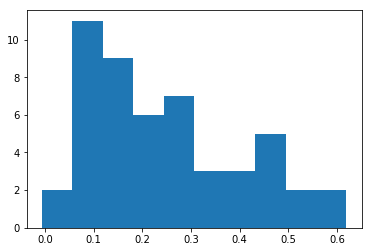

(0.20906870783752649, 0.2491699488099759)

In [41]:
imputed = expected_frequencies_starmap[:, idx_genes_imputed]
imputed /= np.sum(expected_frequencies_starmap[:, vae.indexes_to_keep], axis=1).ravel()[:, np.newaxis]
imputed *= np.sum(gene_dataset_starmap.X[:, vae.indexes_to_keep], axis=1)[:, np.newaxis]
l = np.array([imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], imputed[:, t])["spearman"] 
          for t, idx_gene1 in enumerate(idx_genes_imputed)])
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

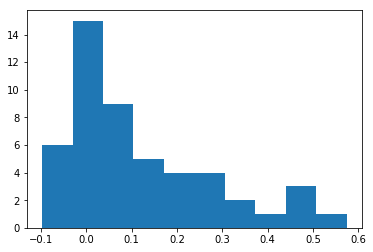

(0.04051647921754563, 0.11717457862092491)

In [42]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_PCA = proximity_imputation(PCA_latent_seq, gene_dataset_seq.X[:, idx_gene1], PCA_latent_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_PCA)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

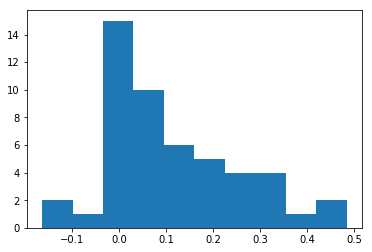

(0.08378882220122222, 0.11429354656213066)

In [43]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_mnn = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, idx_gene1], mnn_latent_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_mnn)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

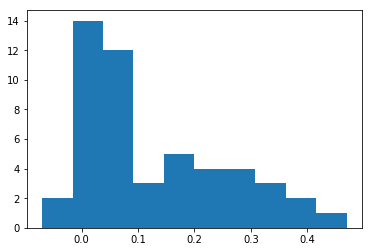

(0.07096648369722695, 0.12438802666339044)

In [44]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_scvi = proximity_imputation(latent_scvi_seq, gene_dataset_seq.X[:, idx_gene1], latent_scvi_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_scvi)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

In [ ]:
# #here we also use our model's latent reprensentation of the cells but rather than using the output 
# #of the generative model in order to impute the missing values for the starmap cells we use a knn approach on the 
# #latent space, just like the baselines
# predicted = proximity_imputation(latent_seq, gene_dataset_seq.X[:, idx_gene1], latent_starmap, k=5)
# #plot_imputation(np.log(1 + predicted), np.log(1 + gene_dataset_starmap.X[:, idx_gene1]))
# print(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted))

# 4. Getting a common meaningful representation

In [67]:
def get_common_umap(latent_seq, latent_fish):
    full_latent = np.concatenate((latent_seq, latent_fish))
    if full_latent.shape[1] != 2:
        latent =  umap.UMAP().fit_transform(full_latent)
    return latent[:latent_seq.shape[0], :], latent[latent_seq.shape[0]:, :]

t_sne_seq, t_sne_starmap = get_common_umap(latent_seq, latent_starmap)
t_sne_PCA_seq, t_sne_PCA_starmap = get_common_umap(PCA_latent_seq, PCA_latent_starmap)
t_sne_mnn_seq, t_sne_mnn_starmap = get_common_umap(mnn_latent_seq, mnn_latent_starmap)
t_sne_scvi_seq, t_sne_scvi_starmap = get_common_umap(latent_scvi_seq, latent_scvi_starmap)

In [72]:
batch_indices = np.concatenate(
    (np.zeros(gene_dataset_starmap.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0])))
flip_idx = np.random.permutation(np.arange(latent.shape[0]))

In [76]:
flip_idx

array([ 1210,  3603, 11105, ...,  2152, 16767,  5331])

## Our method: Embedding of the two datasets in the shared latent space

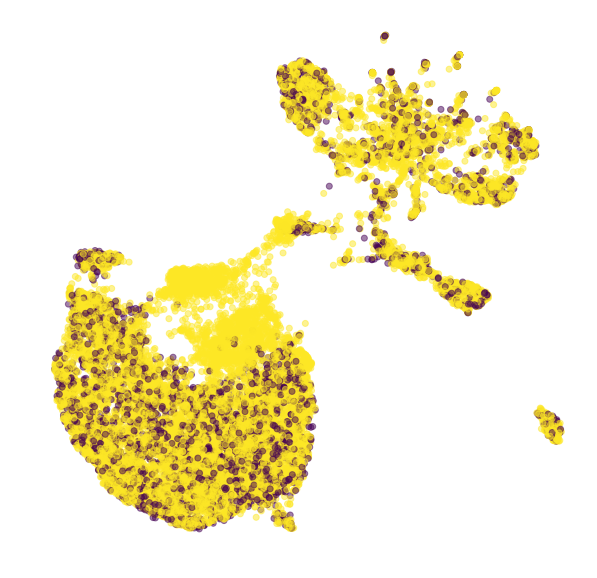

In [80]:
latent = np.concatenate((t_sne_seq, t_sne_starmap), axis=0)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

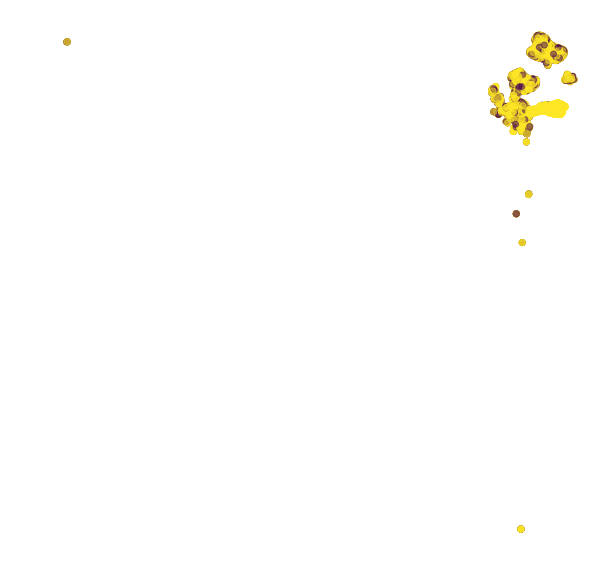

In [81]:
latent = np.concatenate((t_sne_PCA_seq, t_sne_PCA_starmap), axis=0)
# trainer.train_seq.show_t_sne(None, color_by = 'batches', 
#                              latent = latent, 
#                              batch_indices = batch_indices, n_batch=2)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

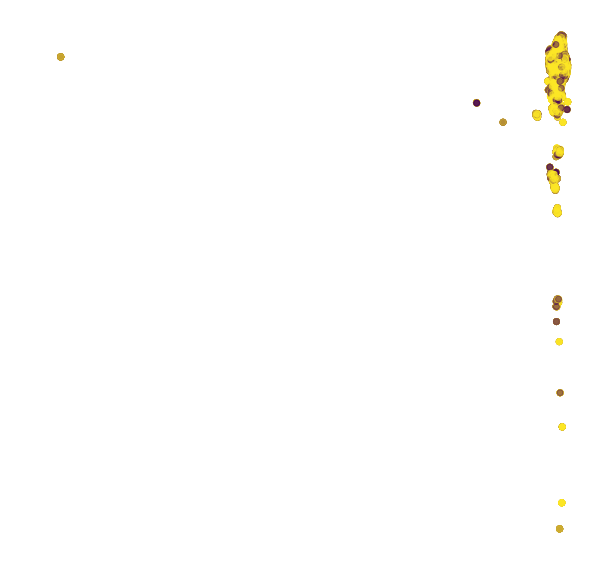

In [82]:
latent = np.concatenate((t_sne_mnn_seq, t_sne_mnn_starmap), axis=0)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

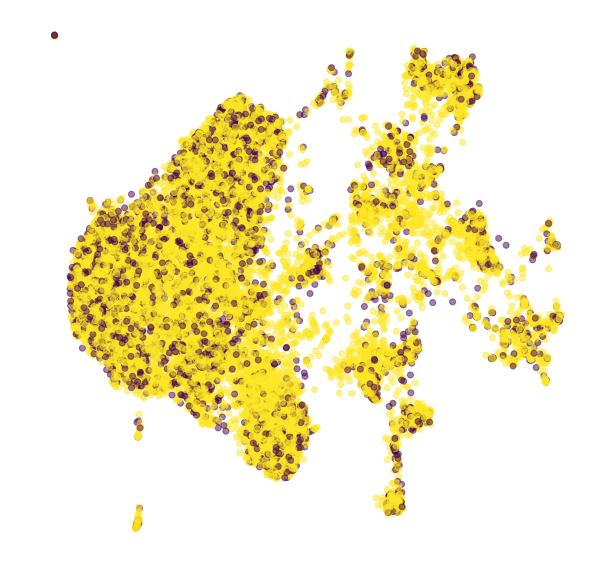

In [83]:
latent = np.concatenate((t_sne_scvi_seq, t_sne_scvi_starmap), axis=0)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

## Batch entropy: How well do the datasets mix in the latent space?

In [84]:
entropy_batch_mixing(np.concatenate((latent_seq, latent_starmap)),
                           batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.19876533409553016

In [85]:
entropy_batch_mixing(np.concatenate((PCA_latent_seq, PCA_latent_starmap)),
                               batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.140363378961686

In [86]:
entropy_batch_mixing(np.concatenate((mnn_latent_seq, mnn_latent_starmap)),
                               batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.5999025407066069

In [87]:
entropy_batch_mixing(np.concatenate((latent_scvi_seq, latent_scvi_starmap)),
                               batches=np.concatenate((np.zeros(latent_scvi_seq.shape[0]),
                                                  np.ones(latent_scvi_starmap.shape[0]))))

0.48369394967251317

In [ ]:
def allow_notebook_for_test():
    print("Testing the scRNA and starMAP notebook")
    
# don't mind this, it is used only when the travis build tests the notebooks